epoch:  0 loss:  13029.924072630283
epoch:  500 loss:  5083.633891482704
epoch:  1000 loss:  3200.420827185596
epoch:  1500 loss:  2815.218345583878
epoch:  2000 loss:  2734.6821528076853
epoch:  2500 loss:  2707.529612319369
epoch:  3000 loss:  2692.7678751530734
epoch:  3500 loss:  2682.784788900892
epoch:  4000 loss:  2675.414581099561
epoch:  4500 loss:  2669.6977819167278
epoch:  5000 loss:  2665.103904693289
epoch:  5500 loss:  2661.313471600887
epoch:  6000 loss:  2658.124724520588
epoch:  6500 loss:  2655.4046990048255
epoch:  7000 loss:  2653.0617950437268
epoch:  7500 loss:  2651.0300139850624
epoch:  8000 loss:  2649.259746607142
epoch:  8500 loss:  2647.7122904181733
epoch:  9000 loss:  2646.3565119761133
epoch:  9500 loss:  2645.166757747768
epoch:  10000 loss:  2644.1215026256214
epoch:  10500 loss:  2643.2024425227346
epoch:  11000 loss:  2642.3938605599587
epoch:  11500 loss:  2641.6821665332986
epoch:  12000 loss:  2641.0555496745956
epoch:  12500 loss:  2640.503708122

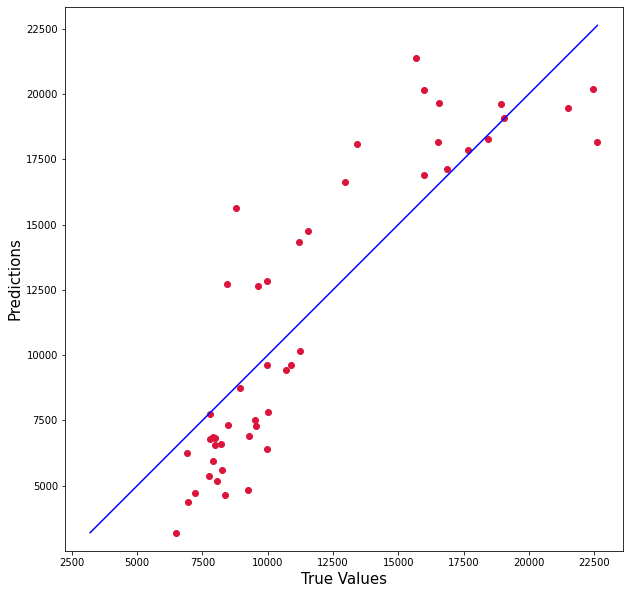

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pl
import math

########################################
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
########################################

class Data:
  def __init__(self, loc):
    self.data = pd.read_csv(loc)
    header = ['symboling','normalized-losses','make','fuel-type','aspiration','num-of-doors','body-style','drive-wheels','engine-location','wheel-base','length','width','height','curb-weight','engine-type','num-of-cylinders','engine-size','fuel-system','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']
    self.data.columns = header
    self.__processData()
    self.__setFeatureAndTarget()

  #return whole data set
  def getData(self):
    return self.data

  #private preprocessing function
  def __processData(self):

    self.data.replace('?',np.nan, inplace=True)
    self.data.dropna(inplace=True)

    self.data['normalized-losses'] = self.data['normalized-losses'].astype('int')
    self.data['bore'] = self.data['bore'].astype('float')
    self.data['stroke'] = self.data['stroke'].astype('float')
    self.data['horsepower'] = self.data['horsepower'].astype('float')
    self.data['peak-rpm'] = self.data['peak-rpm'].astype('int')
    self.data['price'] = self.data['price'].astype('int')
    self.data = self.data.select_dtypes(exclude=['object'])

  #private set date to required features and target
  def __setFeatureAndTarget(self):  
    self.data = self.data[["highway-mpg", "curb-weight", "horsepower", "engine-size", "price"]]

  def getDataSplit(self):  
    train_size = int(0.7 * len(self.data))

    train_set = self.data[:train_size]
    test_set = self.data[train_size:]
    X_train = train_set.iloc[:, :-1]
    X_test = test_set.iloc[:, :-1]
    Y_train = train_set.iloc[:, -1]
    Y_test = test_set.iloc[:, -1]

    #TODO: write standardScalar function to transform X_train and X_test without using sklearn
    ########################################################
    s = StandardScaler() 
    X_train = pd.DataFrame(s.fit(X_train).fit_transform(X_train)) 
    X_test = pd.DataFrame(s.fit(X_test).fit_transform(X_test))
    ########################################################

    return (X_train, X_test, Y_train, Y_test)



class Model:
  #initialize model
  def __init__(self, X, Y):
    self.weights  = np.random.randn(X.shape[1])
    self.X = X.to_numpy()
    self.Y = Y.to_numpy()
    self.bias = 0

  #update the weights and bias
  def update(self, Y_pred, alpha):  

    n = len(self.Y)
    weight_gradient = 0.0
    bias_gradient = 0.0

    for i in range(n):
      weight_gradient += (-2/float(n)) * self.X[i].T.dot(self.Y[i]-Y_pred[i])
      bias_gradient += (-2/float(n)) * (self.Y[i]-Y_pred[i])

    self.weights = self.weights - (alpha * weight_gradient)  
    self.bias = self.bias - (alpha * bias_gradient)

  #train model for specified epochs
  def train(self, alpha, epoch):  
    for _ in range(epoch):
      Y_pred = self.predict(self.X)
      self.update(Y_pred, alpha)
      if _ % 500 == 0:
        print("epoch: ", _, "loss: ", self.loss(self.Y, Y_pred))

    print(self.r2(self.X, self.Y))
           
  #based on current weights and bias predict the target for our dataset        
  def  predict(self, X):
    Y_pred=[]
    n = len(X)
    Y_pred = X.dot(self.weights) + self.bias 
    return np.array(Y_pred)      

  #returns root mean squared error
  def loss(self, Y, Y_pred):
      n = len(Y)
      l = 0
      for i in range(n):
          l+=(Y[i]-Y_pred[i])**2
      return math.sqrt((1/n)*l)
      
  #returns r2 of the model 
  def r2(self, X, Y):
    return r2_score(Y, self.predict(X)) #TODO: write r2 function without sklearn




if __name__ == "__main__":
  #clean and process data
  data = Data('imports-85.data') #TODO: add github/utd link to access data

  #split into training and testing sets
  X_train, X_test, Y_train, Y_test = data.getDataSplit()

  #train model 
  linearRegression = Model(X_train, Y_train)
  linearRegression.train(0.001, 20000)

  #predictions for test set
  Y_test_pred = linearRegression.predict(X_test)

  #evaluation for test set
  Y_test = Y_test.to_numpy()
  rmse = linearRegression.r2(X_test, Y_test)
  r2 = linearRegression.loss(Y_test, Y_test_pred)
  print("rmse: ", rmse)
  print("r2: ", r2)

  #plot of expected value and predicted value on test set
  pl.figure(figsize=(10,10))
  pl.scatter(Y_test, Y_test_pred, c='crimson')
  p1 = max(max(Y_test_pred), max(Y_test))
  p2 = min(min(Y_test_pred), min(Y_test))
  pl.plot([p1, p2], [p1, p2], 'b-')
  pl.xlabel('True Values', fontsize=15)
  pl.ylabel('Predictions', fontsize=15)
  pl.axis('equal')
  pl.show()